Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [1]:
NAME = "Michal Marciniak"

---

# Bayesowskie Sieci Neuronowe (ang. *Bayesian Neural Networks*)

BSN (Bayesowskie Sieci Neuronowe) są rozszerzeniem tradycyjnych sieci neuronowych o elementy wnioskowania i uczenia Bayesowskiego. Wśród zalet tych sieci możemy wskazać:
- możliwość pomiaru niepewności modelu (*uncertainty*) dla predykcji (przy różnych poziomach pewności - ang. *confidence levels*)
- istnieje możliwość zakodowanie wiedzy apriori na temat rozkładu wag sieci

## Podejście Bayesowskie

W przypadku zwykłych sieci neuronowych parametry (wagi) sieci estymujemy metodą Maximum Likelihood, która maksymalizuje prawdopodobieństwo obserwowania danych $\mathcal{D}$ pod warunkiem parametrów $\mathbf{w}$:

$$
\text{arg max}_\theta p(\mathcal{D}|\mathbf{w})
$$

Skutkiem tego jest punktowa estymata parametrów, która nie pozwala modelować niepewności. Możemy jednak wykorzystać twierdzenie Bayesa i przekształcić problem do **uczenia rozkładu parametrów modelu**: 

$$
p(\mathbf{w} | \mathcal{D}) = \frac{p(\mathcal{D}|\mathbf{w})p(\mathbf{w})}{p(\mathcal{D})}
$$

W ten sposób opisujemy rozkład posteriora, gdzie $p(\mathbf{w})$ to wiedza apriori na temat parametrów (wag) modelu. Używając wnioskowania Bayesowskiego, możemy uzyskać predykcje modelu obliczając całkę po całej przestrzeni parametrów $\mathbf{w}$:


$$
p(y | x, \mathcal{D}) = \int p(y | x,\mathbf{w}) p(\mathbf{w} | \mathcal{D})\, d\mathbf{w}
$$

Oczywiście taka całka jest praktycznie nie możliwa do policzenia - z jednej strony mamy nieskończenie wiele możliwych wartości parametrów, a ponadto nie znamy rozkładu danych.

W literaturze zaproponowano kilka możliwych aproksymacji tego problemu:
- jedną z nich jest [Stochastic Variational Inference](http://jmlr.org/papers/v14/hoffman13a.html) (2014) **i na niej skupimy się w tym zeszycie**
- Monte Carlo Markov Chain (MCMC)


Alternatywnie zamiast aproksymować rozkład predykcyjny możemy zaproksymować całą Bayesowską sieć neuronową -- np. za pomocą mechanizmu Dropout, w postaci metody Monte Carlo Dropout: [Yarin Gal and Zoubin Ghahramani in "Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning"](https://arxiv.org/abs/1506.02142)

## Variational inference

Na początku chcielibyśmy policzyć rozkład posterior parametrów $p(\mathbf{w}|\mathcal{D})$. Nie znamy tego rozkładu ani nie jesteśmy w stanie policzyć rozkładu danych $p(\mathcal{D})$. Możemy jednak wykorzystać mechanizm Variational Inference. Określamy rozkład wariacyjny (ang. *variational distribution*), który pochodzi z rodziny znanych nam rozkładów (np. rozkład normalny) i powinien aproksymować skomplikowany nieznany nam rozkład. W poniższych wyprowadzeniach będziemy rozważać gausowski rozkład wariacyjny:

$$
q_\theta(\mathbf{w}) \approx p(\mathbf{w} | \mathcal{D})
$$

$\theta$ to parametry rozkładu wariacyjnego. W celu pomiaru jak dobrze rozkład wariacyjny aproksymuje ten pożądany (rzeczywisty) rozkład musimy określić pewną miarę odległości. Wykorzystamy dywergencję Kullbacka-Leiblera. Podczas optymalizacji problemu, będziemy poszukiwać optymalnych (najlepszych) parametrów rozkładu wariacyjnego, które minimalizują dywergencję KL:

$$
\theta_{opt} = \text{arg min}_\theta \text{KL}\left[q_\theta(\mathbf{w}) || p(\mathbf{w}|\mathcal{D}) \right]
$$

Dywergencja Kullbacka-Leiblera jest określona w następujący sposób:

$$
\text{KL}\left[q_\theta(\mathbf{w})||p(\mathbf{w} | \mathcal{D}) \right] = \int q_\theta(\mathbf{w}) \log\frac{q_\theta(\mathbf{w})}{p(\mathbf{w}|\mathcal{D})}\, d\mathbf{w}
$$

Aby policzyć tę całkę musimy znać rozkład posteriora $p(\mathbf{w}|\mathcal{D})$, dlatego stosujemy następujące przekształcenie:


$$
\begin{align}
\theta_{opt} &= \text{arg min}_\theta \text{KL}\left[q_\theta(\mathbf{w})||p(\mathbf{w} | \mathcal{D}) \right] \\
&= \text{arg min}_\theta \int q_\theta(\mathbf{w}) \log\frac{q_\theta(\mathbf{w})}{p(\mathbf{w})p(\mathcal{D}|\mathbf{w})}\, d\mathbf{w}\\
&= \text{arg min}_\theta \text{KL}\left[q_\theta(\mathbf{w})||p(\mathbf{w}) \right] - {\mathbb{E}}_{q_\theta(\mathbf{w})}\left[log p(\mathcal{D}|\mathbf{w})\right]
\end{align}
$$

Tę wartość nazywamy [Evidence Lower Bound (ELBO)](https://en.wikipedia.org/wiki/Evidence_lower_bound)

Aby uzyskać nieobciążone estymatory gradientów ELBO możemy zastosować estymację Monte Carlo losując wagi modelu $N$-krotnie i sumując wyniki kilku takich losowań. Podsumowując, optymalne wagi znajdujemy w następujący sposób:

$$\tag{1}
\theta_{opt} = \text{arg min}_\theta \frac{1}{N}\sum^N_{i=1} \log q_\theta(\mathbf{w}^{(i)}) - \log p(\mathbf{w}^{(i)}) - \log p(\mathcal{D}|\mathbf{w}^{(i)})
$$

gdzie $\mathbf{w}^{(i)}$ jest próbkowane z rozkładu $q_\theta(\mathbf{w})$. Zauważ, że ostatni człon $\log p(\mathcal{D}|\mathbf{w}^{(i)})$ to funkcja likelihood zwykłej sieci neuronowej.

## Sztuczka z reparametryzacją (ang. *reparametrization trick*)

Kolejnym problemem jest związanym z powyższą metodą jest brak możliwości obliczania pochodnych (brak różniczkowalności) w procesie optymalizacji parametrów sieci. Rozwiązaniem jest wykorzystanie sztuczki z reparametryzację (więcej szczegółów znajdziesz w [Variational Dropout and the Local Reparameterization Trick](https://arxiv.org/abs/1506.02557)). Zakładając, że chcemy wykorzystywać rozkład normalny, każdy wyuczalny parametr (waga) sieci $\theta$ będzie określony przez dwa inne parametry - średnią  $\mu$ oraz wariancję  $\sigma^2$ rozkładu normalnego:

$$
\theta = (\mu, \sigma^2)
$$

Używając sztuczki z reparametryzacją otrzymujemy:

$$
f(\epsilon) = \theta = \mu + \sigma \cdot \epsilon
$$

gdzie $\epsilon$ jest losowany z rozkładu normalnego standardowego:

$$
\epsilon \sim \mathcal{N}(0, 1)
$$

Jednym nieróżniczkowalnym członem jest $\epsilon$, jednak zależy nam głównie na parametrach $\mu$ oraz $\sigma$. Możemy policzyć gradienty w następujący sposób (w rzeczywistości biblioteki do uczenia sieci neuronowych obliczają te pochodne za nas):

$$
\begin{align}
    \Delta_\mu &= \frac{\partial f}{\partial \theta} + \frac{\partial f}{\partial \mu} \\
    \Delta_\sigma &= \frac{\partial f}{\partial \theta} \frac{\epsilon}{\sigma} + \frac{\partial f}{\partial \sigma}
\end{align}
$$

Parametry są aktualizowane w następujący sposób:

$$
\begin{align}
    \mu^{(t+1)} &= \mu^{t} - \alpha \Delta_\mu \\
    \sigma^{(t+1)} &= \sigma^t - \alpha \Delta_\sigma
\end{align}
$$

Tak zdefiniowane uczenie jest nazywane _Bayes by Backprop_ i jest kluczowym elementem Bayesowskich Sieci Neuronowych.

In [2]:
import torch
import torch.nn as nn
import math

# Prior

Poniższa implementacja bayesowskich sieci neuronowych jest oparta na pracy `https://arxiv.org/pdf/1505.05424.pdf`. Najpierw zaimplementujmy prior dla wag sieci. Wykorzystana będzie tutaj mikstura dwóch rozkładów normalnych. Implementacja ta jest zgodna z opisem w punkcie `3.3. Scale mixture prior` w przytoczonej publikacji.

In [3]:
class TwoGaussianMixturePrior:
    
    def __init__(
        self, 
        sigma_1: float = 1, 
        sigma_2: float = 1e-6, 
        mixing: float = 0.5,
    ):
        self.mixing = mixing
        
        self.w_prior_1 = torch.distributions.Normal(0, sigma_1)
        self.w_prior_2 = torch.distributions.Normal(0, sigma_2)
        
        self.b_prior_1 = torch.distributions.Normal(0, sigma_1)
        self.b_prior_2 = torch.distributions.Normal(0, sigma_2)
        
    def log_prob(self, weights: torch.Tensor, biases: torch.Tensor):
        w_log_prior_1 = self.w_prior_1.log_prob(weights).exp()
        w_log_prior_2 = self.w_prior_2.log_prob(weights).exp()
        
        w_prior = self.mixing * w_log_prior_1 + (1 - self.mixing) * w_log_prior_2
        
        b_log_prior_1 = self.b_prior_1.log_prob(biases).exp()
        b_log_prior_2 = self.b_prior_2.log_prob(biases).exp()
        
        b_prior = self.mixing * b_log_prior_1 + (1 - self.mixing) * b_log_prior_2
    
        # We don't want this log probability to depend on 
        # the actual number of network parameters (weights+biases),
        # so we compute the mean instead of a sum.
        return w_prior.log().mean() + b_prior.log().mean()

# Zadanie 1 (2 pkt) - Liniowa warstwa Bayesowska
Uzupełnij poniższą implementację bayesowskiej warstwy liniowej. Pamiętaj, że w omówionym podejściu wykorzystujemy rozkład normalny, a każda waga sieci jest określona przez parametry: $\mu$ oraz $\sigma^2$. 

- w funkcji `__init__()` zadeklaruj i zainicjuj wyuczalne parametry rozkładów normalnych, osobno dla wag sieci (`weight`) oraz obciążeń (`biases`)
- w funkcji `forward()` wylosuj wagi oraz obciążenia z przygotowanych rozkładów; użyj sztuczki z reparametryzacją; pamiętaj, że wariancja/odchylenie standardowe nie może być ujemne (zobacz rozdział: `3.2. Gaussian variational posterior` w podanej publikacji)
- w funkcji `variational_log_prob()` oblicz logarytm prawdopodobieństwa wariacyjnego $\log q_\phi(\theta^{(i)} | \mathcal{D}) $

In [4]:
class BayesianLinear(nn.Module):
    """Main reference: https://arxiv.org/pdf/1505.05424.pdf"""
    
    def __init__(
        self, 
        num_input_features: int,
        num_output_features: int,
        prior: TwoGaussianMixturePrior,
    ):
        """Implement initialization of weights and biases values"""
        super().__init__()
        
        self.prior = prior
        
        self.last_weights_ = None
        self.last_biases_ = None
        
        # Define weights parameters and initialize them using uniform distribution
        # TU WPISZ KOD
        self.weights_mean = nn.Parameter(torch.Tensor(num_input_features, num_output_features))
        self.weights_sigma = nn.Parameter(torch.Tensor(num_input_features, num_output_features))
        
        self.weights_mean.data.uniform_(-0.1, 0.1)
        self.weights_sigma.data.uniform_(-2, -1)
        
        # Define biases parameters and initialize them using uniform distribution
        # TU WPISZ KOD
        self.bias_mean = nn.Parameter(torch.Tensor(num_output_features))
        self.bias_sigma = nn.Parameter(torch.Tensor(num_output_features))
        
        
        self.bias_mean.data.uniform_(-0.1, 0.1)
        self.bias_sigma.data.uniform_(-2, -1)
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Implement forward inference using reparametrization trick"""
        weights = ...
        biases = ...
        
        # TU WPISZ KOD
        w_epsilon = torch.randn_like(self.weights_sigma)
        b_epsilon = torch.randn_like(self.bias_sigma)
        weights = self.weights_mean + torch.log1p(torch.exp(self.weights_sigma)) * w_epsilon
        biases = self.bias_mean + torch.log1p(torch.exp(self.bias_sigma)) * b_epsilon
        
        self.last_weights_ = weights
        self.last_biases_ = biases
        
        return x @ weights + biases
        
    def prior_log_prob(self) -> torch.Tensor:
        """Calculates the prior log prob of sampled weights and biases."""
        return self.prior.log_prob(weights=self.last_weights_, biases=self.last_biases_)
        
    def variational_log_prob(self) -> torch.Tensor:
        """Implement the variational log prob."""
        # TU WPISZ KOD
        w_dist = torch.distributions.Normal(self.weights_mean, torch.log1p(torch.exp(self.weights_sigma)))
        b_dist = torch.distributions.Normal(self.bias_mean, torch.log1p(torch.exp(self.bias_sigma)))
        
        w_log_prob = w_dist.log_prob(self.last_weights_)
        b_log_prob = b_dist.log_prob(self.last_biases_)
        
        
        return w_log_prob.mean() + b_log_prob.mean()

### Bayesowski Wielowarstwowy Perceptron
Używając powyższej bayesowskiej wartstwy liniowej możemy zaimplementować bayesowską wersję wielowarstwowego perceptrona (ang. *MLP*). 

In [5]:
class BayesianMLP(nn.Module):
    def __init__(
        self, 
        num_input_features: int,
        num_hidden_features: int,
        num_output_classes: int,
        sigma_1: 1,
        sigma_2: 1e-6,
        mixing: 0.5
    ):
        super().__init__()
        
        self.layer_1 = BayesianLinear(
            num_input_features, num_hidden_features, 
            prior=TwoGaussianMixturePrior(sigma_1, sigma_2, mixing),
        )
        self.layer_2 = BayesianLinear(
            num_hidden_features, num_output_classes, 
            prior=TwoGaussianMixturePrior(sigma_1, sigma_2, mixing),
        )
        
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.sigmoid(self.layer_1(x))
        x = self.softmax(self.layer_2(x))
        return x
        
    def prior_log_prob(self) -> torch.Tensor:
        log_prob = 0
        for module in self.modules():
            if isinstance(module, BayesianLinear):
                log_prob += module.prior_log_prob()
        return log_prob
        
    def variational_log_prob(self) -> torch.Tensor:
        log_prob = 0
        for module in self.modules():
            if isinstance(module, BayesianLinear):
                log_prob += module.variational_log_prob()
        return log_prob

# Zadanie 2 (1.5 pkt) - ELBO dla `N` próbek Monte Carlo
Zaimplementuj liczenie ELBO korzystając ze wzoru $(1)$. Zastosuj funkcję kosztu `Negative Log Likelihood (NLL)` i pamiętaj, że w ten sposób człon: $- \log p(\mathcal{D}|\mathbf{w}^{(i)})$ będzie w pełni obliczany przez NLL (jego wartość należy dodać do łącznego kosztu, a nie odejmować!). Dodatkowo należy podkreślić, że log likelihood próbki danych to suma log likelihood'ów każdego z elementów zbioru.

In [6]:
from typing import Union, Tuple


class ELBO(nn.Module):
    def __init__(self, N: int):
        super().__init__()
        
        self.N = N
        self.nll = nn.NLLLoss(reduction="none")
        
    def forward(
        self, 
        model: nn.Module, 
        inputs: torch.Tensor,
        targets: torch.Tensor,
        *,
        return_predictions: bool = False,
    ) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """Calculate loss according to the equation (2) of https://arxiv.org/abs/1505.05424"""
        predictions = []
        log_posteriors = []
        log_priors = []
        
        nll_loss = 0
        for _ in range(self.N):
            preds = model(inputs)
            
            # TU WPISZ KOD
            predictions.append(preds)
            log_posteriors.append(model.variational_log_prob())
            log_priors.append(model.prior_log_prob())
            nll_loss += self.nll(torch.log(preds), torch.argmax(targets,dim=1)).sum()
            
        loss = (sum(log_posteriors) + sum(log_priors) + nll_loss) / self.N

        
        if return_predictions:
            return loss, torch.stack(predictions, dim=-1)
        return loss

In [7]:
from src import utils

## Ewaluacja modelu
Wykorzystamy tutaj zbiór MNIST (ręcznie pisanych cyfr) i wykonamy kilka analiz, aby zobaczyć gdzie model był pewien swoich decyzji (zarówno tych poprawnych jak i błędnych) oraz zobaczymy przykłady, gdzie model nie był pewien predykcji.

In [8]:
train_dataset, test_dataset = utils.load_mnist_datasets(limit_train_samples_to=1_000)

In [9]:
model = BayesianMLP(
    num_input_features=28 * 28,  # pixels
    num_hidden_features=128,  # arbitrary number
    num_output_classes=10,  # num of digits
    sigma_1 = 1, 
    sigma_2 = 1e-6, 
    mixing = 0.5,
)

loss_fun = ELBO(N=10)
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=1e-3, 
)

In [10]:
train_metrics, test_metrics = utils.fit_elbo(
    model=model,
    train_dataset=train_dataset,
    valid_dataset=test_dataset,
    loss_function=loss_fun,
    batch_size=32,
    epochs=20,
    optimizer=optimizer,
)

Epoch: 1 / 20



Epoch: 2 / 20



Epoch: 3 / 20



Epoch: 4 / 20



Epoch: 5 / 20



Epoch: 6 / 20



Epoch: 7 / 20



Epoch: 8 / 20



Epoch: 9 / 20



Epoch: 10 / 20



Epoch: 11 / 20



Epoch: 12 / 20



Epoch: 13 / 20



Epoch: 14 / 20



Epoch: 15 / 20



Epoch: 16 / 20



Epoch: 17 / 20



Epoch: 18 / 20



Epoch: 19 / 20



Epoch: 20 / 20


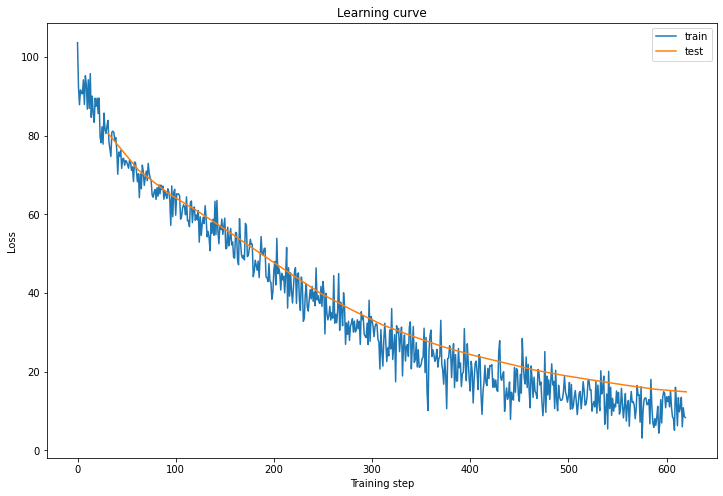

In [11]:
utils.show_learning_curve(train_metrics, test_metrics)

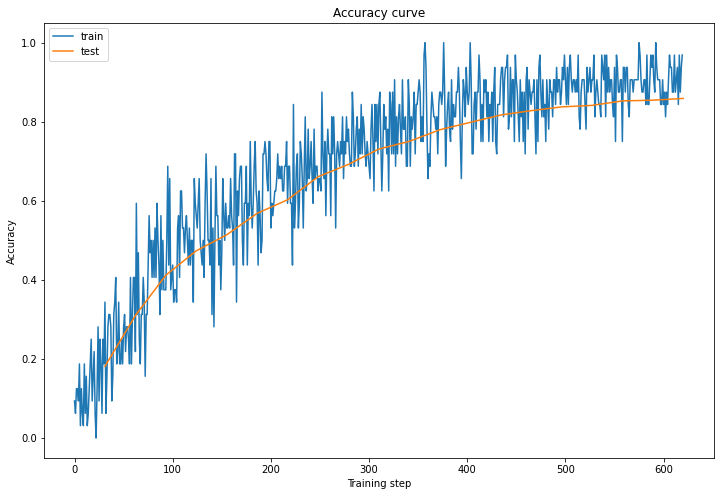

In [12]:
utils.show_accuracy_curve(train_metrics, test_metrics)

In [16]:
print(f"Best training accuracy: {max(train_metrics['acc'])}")
print(f"Best testing accuracy: {max(test_metrics['acc'])}")

Best training accuracy: 1.0
Best testing accuracy: 0.859000027179718


In [17]:
num_samplings = 10
analyzer = utils.Analyzer(model, test_dataset, num_samplings)

Top high confidence correct predictions


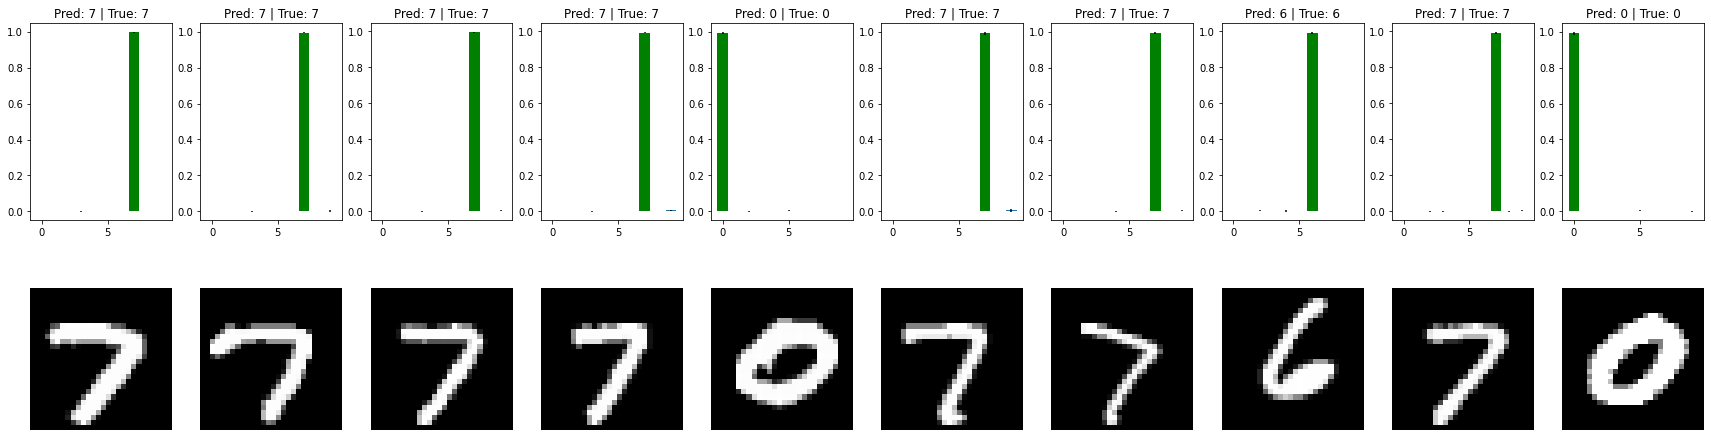

In [18]:
utils.visualize_samples(
    *analyzer.get_top_k_high_confidence_correct(10)
)
print("Top high confidence correct predictions")

Top low confidence correct predictions


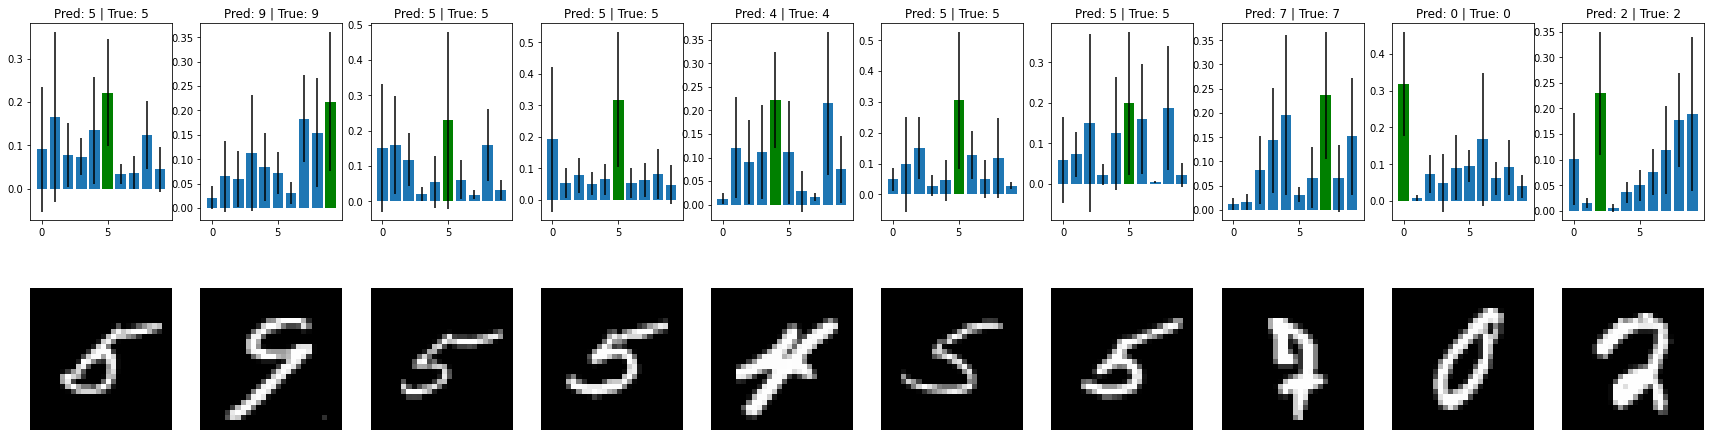

In [19]:
utils.visualize_samples(
    *analyzer.get_top_k_low_confidence_correct(10)
)
print("Top low confidence correct predictions")

Top low confidence wrong predictions


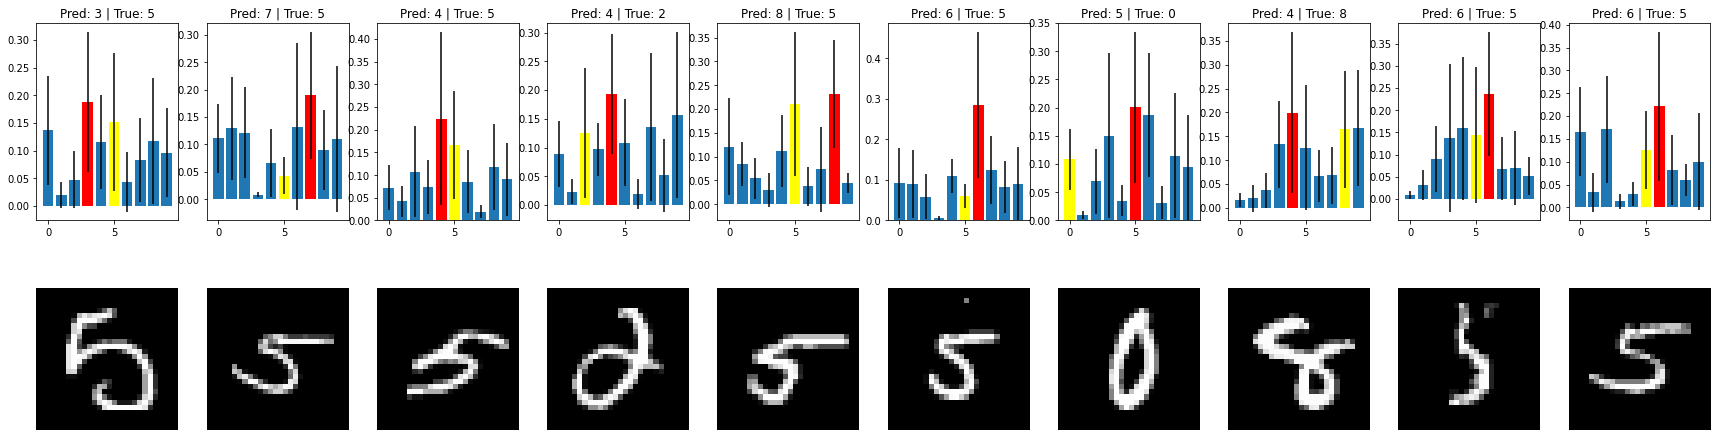

In [20]:
utils.visualize_samples(
    *analyzer.get_top_k_low_confidence_mistakes(10)
)

print("Top low confidence wrong predictions")

Top high confidence wrong predictions


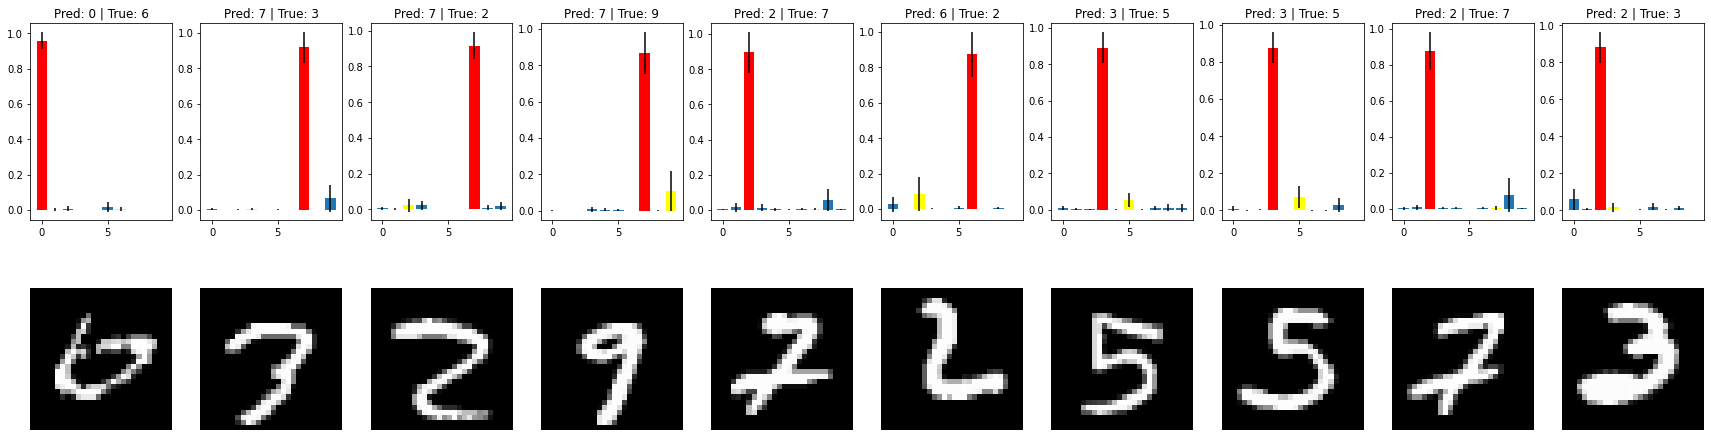

In [21]:
utils.visualize_samples(
    *analyzer.get_top_k_high_confidence_mistakes(10)
)

print("Top high confidence wrong predictions")

# Zadanie 3 (0.1 pkt)
Przypisz do zmiennych `layer_1_means` oraz `layer_2_means` wartości parametrów średnich rozkładu normalnego $\mu$ dla odpowiednio pierwszej i drugiej warstwy.

Histogram of weights for layer 1


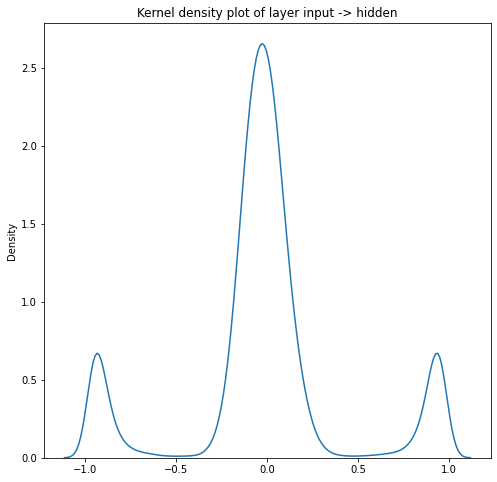

In [22]:
layer_1_means = model.layer_1.weights_mean
utils.visualize_weights(layer_1_means, "layer input -> hidden")
print("Histogram of weights for layer 1")

Histogram of weights for layer 2


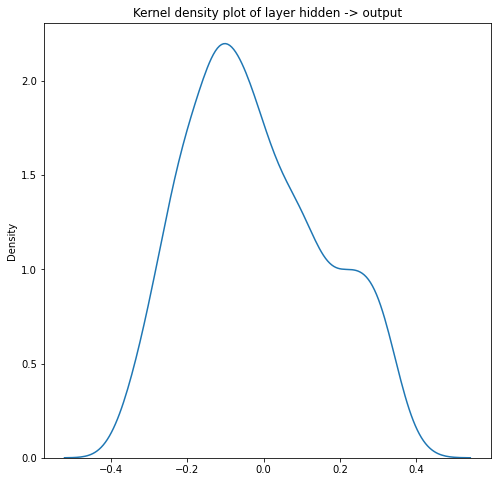

In [23]:
layer_2_means =  model.layer_2.weights_mean

utils.visualize_weights(layer_2_means, "layer hidden -> output")
print("Histogram of weights for layer 2")

# Zadanie 4 (1.4 pkt)
Zbadaj wpływ hiperparametrów na działanie modelu:
- parametry w rozkładzie prior (tzn. `sigma_1`, `sigma_2`, `mixing`)
- co się stanie jeśli zastosujemy tylko jeden rozkład normalny jako prior (zamiast mikstury)?
- rozmiar mini-paczki (`batch_size`)
- współczynnik uczenia (`learning_rate`)

In [13]:
from collections import defaultdict

In [14]:
baseline_batch_size = 32
baseline_lr = 1e-3
baseline_sigma_1 = 1
baseline_sigma_2 = 1e-6
baseline_mixing = 0.5

baseline_train_metrics = train_metrics
baseline_test_metrics = test_metrics

### Wpływ parametrów w rozkładzie prior

In [49]:
sigma_res = defaultdict()
sigma_1_vector = [0.01, 0.1, 2]


for sigma_1 in sigma_1_vector:
    model = BayesianMLP(
        num_input_features=28 * 28,  # pixels
        num_hidden_features=128,  # arbitrary number
        num_output_classes=10,  # num of digits
        sigma_1 = sigma_1,
        sigma_2 = baseline_sigma_2,
        mixing = baseline_mixing
    )

    loss_fun = ELBO(N=10)
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=baseline_lr, 
    )
    
    train_metrics, test_metrics = utils.fit_elbo(
        model=model,
        train_dataset=train_dataset,
        valid_dataset=test_dataset,
        loss_function=loss_fun,
        batch_size=baseline_batch_size,
        epochs=20,
        optimizer=optimizer,
    )
    
    sigma_res[sigma_1] = (train_metrics, test_metrics)

Epoch: 1 / 20



Epoch: 2 / 20



Epoch: 3 / 20



Epoch: 4 / 20



Epoch: 5 / 20



Epoch: 6 / 20



Epoch: 7 / 20



Epoch: 8 / 20



Epoch: 9 / 20



Epoch: 10 / 20



Epoch: 11 / 20



Epoch: 12 / 20



Epoch: 13 / 20



Epoch: 14 / 20



Epoch: 15 / 20



Epoch: 16 / 20



Epoch: 17 / 20



Epoch: 18 / 20



Epoch: 19 / 20



Epoch: 20 / 20



Epoch: 1 / 20



Epoch: 2 / 20



Epoch: 3 / 20



Epoch: 4 / 20



Epoch: 5 / 20



Epoch: 6 / 20



Epoch: 7 / 20



Epoch: 8 / 20



Epoch: 9 / 20



Epoch: 10 / 20



Epoch: 11 / 20



Epoch: 12 / 20



Epoch: 13 / 20



Epoch: 14 / 20



Epoch: 15 / 20



Epoch: 16 / 20



Epoch: 17 / 20



Epoch: 18 / 20



Epoch: 19 / 20



Epoch: 20 / 20



Epoch: 1 / 20



Epoch: 2 / 20



Epoch: 3 / 20



Epoch: 4 / 20



Epoch: 5 / 20



Epoch: 6 / 20



Epoch: 7 / 20



Epoch: 8 / 20



Epoch: 9 / 20



Epoch: 10 / 20



Epoch: 11 / 20



Epoch: 12 / 20



Epoch: 13 / 20



Epoch: 14 / 20



Epoch: 15 / 20



Epoch: 16 / 20



Epoch: 17 / 20



Epoch: 18 / 20



Epoch: 19 / 20



Epoch: 20 / 20


In [29]:
import matplotlib.pyplot as plt

def show_results(result_dict,baseline_key, title):
    fig, axs = plt.subplots(2,2, figsize=(12,10))

    for key in result_dict.keys():
        train_res = result_dict[key][0]
        test_res = result_dict[key][1]
        axs[0][0].plot(train_res['step'], train_res['loss'], label=key)
        axs[0][1].plot(test_res['step'], test_res['loss'], label=key)
        axs[1][0].plot(train_res['step'], train_res['acc'], label=key)
        axs[1][1].plot(test_res['step'], test_res['acc'], label=key)

    axs[0][0].plot(baseline_train_metrics['step'], baseline_train_metrics['loss'], label=baseline_key)
    axs[0][1].plot(baseline_test_metrics['step'], baseline_test_metrics['loss'], label=baseline_key)
    axs[1][0].plot(baseline_train_metrics['step'], baseline_train_metrics['acc'], label=baseline_key)
    axs[1][1].plot(baseline_test_metrics['step'], baseline_test_metrics['acc'], label=baseline_key)

    axs[0][0].set_title('Train Loss')
    axs[0][1].set_title('Test Loss')
    axs[1][0].set_title('Train Acc')
    axs[1][1].set_title('Test Acc')


    plt.setp(axs[:,:],xlabel='step')
    plt.setp(axs[0,:], ylabel='loss')
    plt.setp(axs[1,:], ylabel='acc')
    plt.legend(title = "sigma_1", loc='upper left', bbox_to_anchor=(1.0, 1.2),prop={'size': 14})
    fig.suptitle(title)
    plt.show()
    

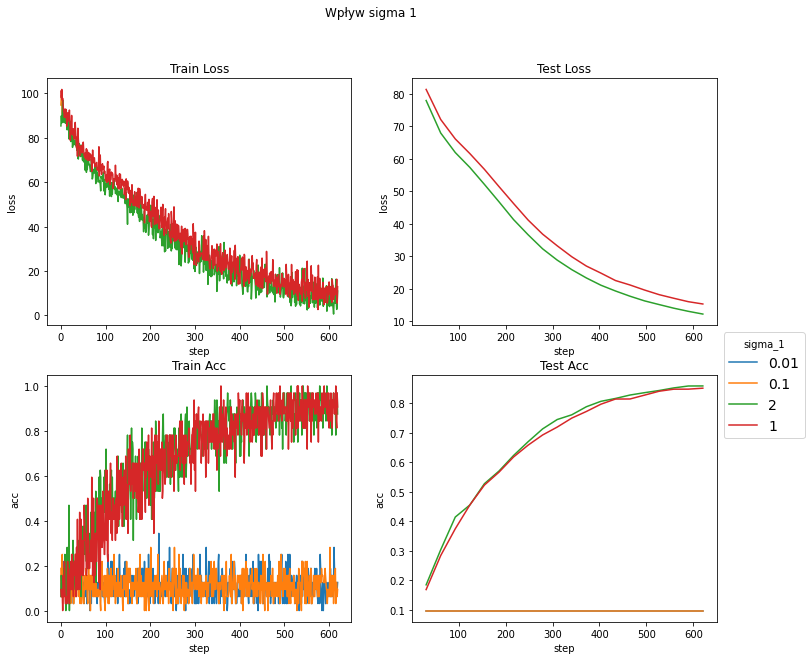

In [78]:

show_results(sigma_res,baseline_sigma_1, 'Wpływ sigma 1')

In [79]:
sigma2_res = defaultdict()
sigma_2_vector = [0, 1e-3, 1]


for sigma_2 in sigma_2_vector:
    model = BayesianMLP(
        num_input_features=28 * 28,  # pixels
        num_hidden_features=128,  # arbitrary number
        num_output_classes=10,  # num of digits
        sigma_1 = baseline_sigma_1,
        sigma_2 = sigma_2,
        mixing = baseline_mixing
    )

    loss_fun = ELBO(N=10)
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=baseline_lr, 
    )
    
    train_metrics, test_metrics = utils.fit_elbo(
        model=model,
        train_dataset=train_dataset,
        valid_dataset=test_dataset,
        loss_function=loss_fun,
        batch_size=baseline_batch_size,
        epochs=20,
        optimizer=optimizer,
    )
    
    sigma2_res[sigma_2] = (train_metrics, test_metrics)

Epoch: 1 / 20



Epoch: 2 / 20



Epoch: 3 / 20



Epoch: 4 / 20



Epoch: 5 / 20



Epoch: 6 / 20



Epoch: 7 / 20



Epoch: 8 / 20



Epoch: 9 / 20



Epoch: 10 / 20



Epoch: 11 / 20



Epoch: 12 / 20



Epoch: 13 / 20



Epoch: 14 / 20



Epoch: 15 / 20



Epoch: 16 / 20



Epoch: 17 / 20



Epoch: 18 / 20



Epoch: 19 / 20



Epoch: 20 / 20



Epoch: 1 / 20



Epoch: 2 / 20



Epoch: 3 / 20



Epoch: 4 / 20



Epoch: 5 / 20



Epoch: 6 / 20



Epoch: 7 / 20



Epoch: 8 / 20



Epoch: 9 / 20



Epoch: 10 / 20



Epoch: 11 / 20



Epoch: 12 / 20



Epoch: 13 / 20



Epoch: 14 / 20



Epoch: 15 / 20



Epoch: 16 / 20



Epoch: 17 / 20



Epoch: 18 / 20



Epoch: 19 / 20



Epoch: 20 / 20



Epoch: 1 / 20



Epoch: 2 / 20



Epoch: 3 / 20



Epoch: 4 / 20



Epoch: 5 / 20



Epoch: 6 / 20



Epoch: 7 / 20



Epoch: 8 / 20



Epoch: 9 / 20



Epoch: 10 / 20



Epoch: 11 / 20



Epoch: 12 / 20



Epoch: 13 / 20



Epoch: 14 / 20



Epoch: 15 / 20



Epoch: 16 / 20



Epoch: 17 / 20



Epoch: 18 / 20



Epoch: 19 / 20



Epoch: 20 / 20


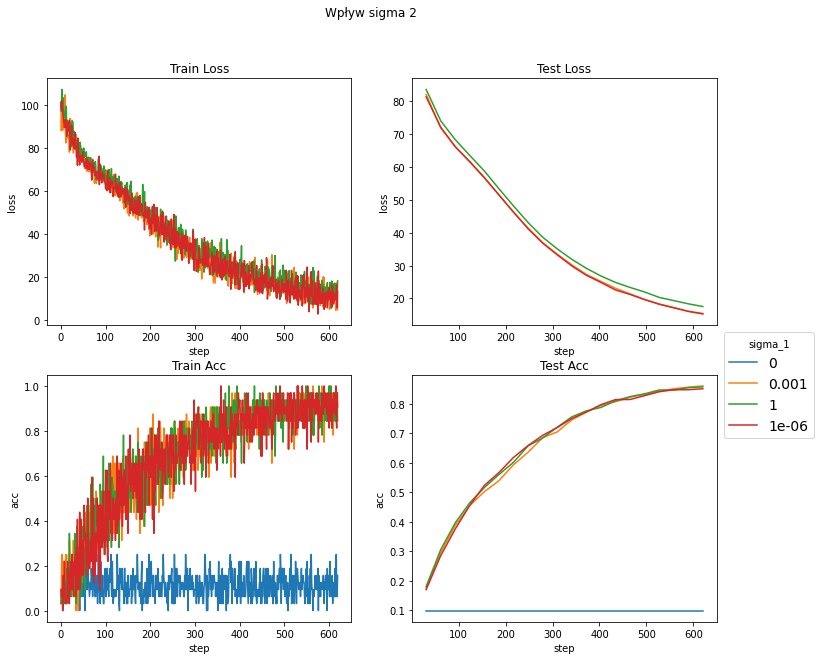

In [81]:
show_results(sigma2_res,baseline_sigma_2, 'Wpływ sigma 2')

In [28]:
mixing_res = defaultdict()
mixing_vector = [0, 0.2, 0.8, 1.0]


for mixing in mixing_vector:
    model = BayesianMLP(
        num_input_features=28 * 28,  # pixels
        num_hidden_features=128,  # arbitrary number
        num_output_classes=10,  # num of digits
        sigma_1 = baseline_sigma_1,
        sigma_2 = baseline_sigma_2,
        mixing = mixing
    )

    loss_fun = ELBO(N=10)
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=baseline_lr, 
    )
    
    train_metrics, test_metrics = utils.fit_elbo(
        model=model,
        train_dataset=train_dataset,
        valid_dataset=test_dataset,
        loss_function=loss_fun,
        batch_size=baseline_batch_size,
        epochs=20,
        optimizer=optimizer,
    )
    
    mixing_res[mixing] = (train_metrics, test_metrics)

Epoch: 1 / 20



Epoch: 2 / 20



Epoch: 3 / 20



Epoch: 4 / 20



Epoch: 5 / 20



Epoch: 6 / 20



Epoch: 7 / 20



Epoch: 8 / 20



Epoch: 9 / 20



Epoch: 10 / 20



Epoch: 11 / 20



Epoch: 12 / 20



Epoch: 13 / 20



Epoch: 14 / 20



Epoch: 15 / 20



Epoch: 16 / 20



Epoch: 17 / 20



Epoch: 18 / 20



Epoch: 19 / 20



Epoch: 20 / 20



Epoch: 1 / 20



Epoch: 2 / 20



Epoch: 3 / 20



Epoch: 4 / 20



Epoch: 5 / 20



Epoch: 6 / 20



Epoch: 7 / 20



Epoch: 8 / 20



Epoch: 9 / 20



Epoch: 10 / 20



Epoch: 11 / 20



Epoch: 12 / 20



Epoch: 13 / 20



Epoch: 14 / 20



Epoch: 15 / 20



Epoch: 16 / 20



Epoch: 17 / 20



Epoch: 18 / 20



Epoch: 19 / 20



Epoch: 20 / 20



Epoch: 1 / 20



Epoch: 2 / 20



Epoch: 3 / 20



Epoch: 4 / 20



Epoch: 5 / 20



Epoch: 6 / 20



Epoch: 7 / 20



Epoch: 8 / 20



Epoch: 9 / 20



Epoch: 10 / 20



Epoch: 11 / 20



Epoch: 12 / 20



Epoch: 13 / 20



Epoch: 14 / 20



Epoch: 15 / 20



Epoch: 16 / 20



Epoch: 17 / 20



Epoch: 18 / 20



Epoch: 19 / 20



Epoch: 20 / 20



Epoch: 1 / 20



Epoch: 2 / 20



Epoch: 3 / 20



Epoch: 4 / 20



Epoch: 5 / 20



Epoch: 6 / 20



Epoch: 7 / 20



Epoch: 8 / 20



Epoch: 9 / 20



Epoch: 10 / 20



Epoch: 11 / 20



Epoch: 12 / 20



Epoch: 13 / 20



Epoch: 14 / 20



Epoch: 15 / 20



Epoch: 16 / 20



Epoch: 17 / 20



Epoch: 18 / 20



Epoch: 19 / 20



Epoch: 20 / 20


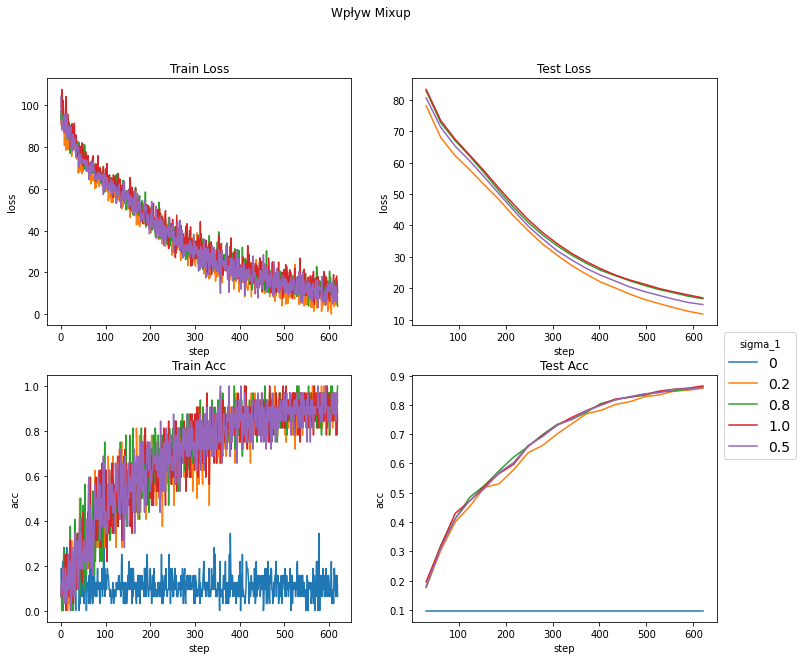

In [30]:
show_results(mixing_res,baseline_mixing, 'Wpływ Mixup')

### Wpływ rozmiaru mini-paczki

In [15]:
import gc

In [26]:
gc.collect()

20

In [27]:
batch_res = defaultdict()
batch_vector = [64, 128]


for batch_size in batch_vector:
    model = BayesianMLP(
        num_input_features=28 * 28,  # pixels
        num_hidden_features=128,  # arbitrary number
        num_output_classes=10,  # num of digits
        sigma_1 = baseline_sigma_1,
        sigma_2 = baseline_sigma_2,
        mixing = baseline_mixing
    )

    loss_fun = ELBO(N=10)
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=baseline_lr, 
    )
    
    train_metrics, test_metrics = utils.fit_elbo(
        model=model,
        train_dataset=train_dataset,
        valid_dataset=test_dataset,
        loss_function=loss_fun,
        batch_size=batch_size,
        epochs=20,
        optimizer=optimizer,
    )
    
    batch_res[batch_size] = (train_metrics, test_metrics)

Epoch: 1 / 20



Epoch: 2 / 20



Epoch: 3 / 20



Epoch: 4 / 20



Epoch: 5 / 20



Epoch: 6 / 20



Epoch: 7 / 20



Epoch: 8 / 20



Epoch: 9 / 20



Epoch: 10 / 20



Epoch: 11 / 20



Epoch: 12 / 20



Epoch: 13 / 20



Epoch: 14 / 20



Epoch: 15 / 20



Epoch: 16 / 20



Epoch: 17 / 20



Epoch: 18 / 20



Epoch: 19 / 20



Epoch: 20 / 20



Epoch: 1 / 20



Epoch: 2 / 20



Epoch: 3 / 20



Epoch: 4 / 20



Epoch: 5 / 20



Epoch: 6 / 20



Epoch: 7 / 20



Epoch: 8 / 20



Epoch: 9 / 20



Epoch: 10 / 20



Epoch: 11 / 20



Epoch: 12 / 20



Epoch: 13 / 20



Epoch: 14 / 20



Epoch: 15 / 20



Epoch: 16 / 20



Epoch: 17 / 20



Epoch: 18 / 20



Epoch: 19 / 20



Epoch: 20 / 20


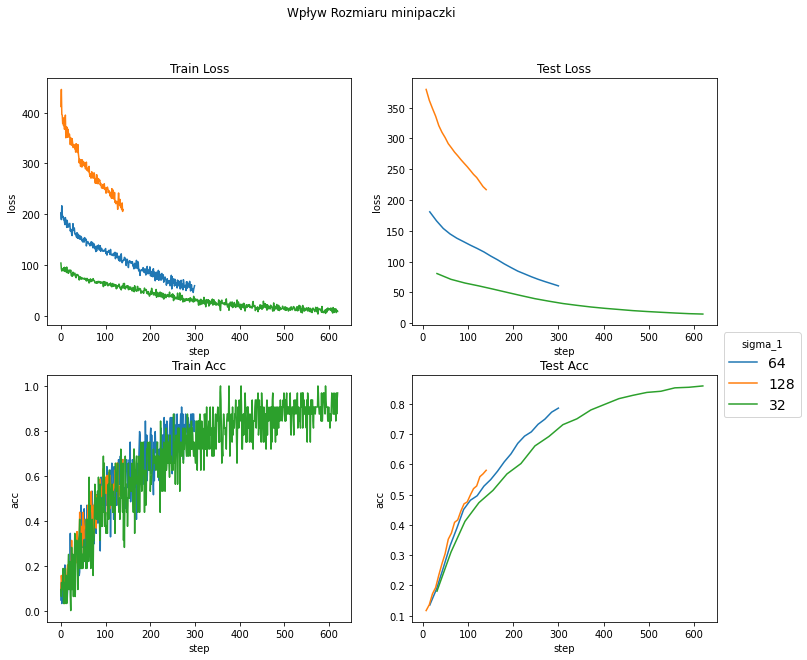

In [30]:
show_results(batch_res,baseline_batch_size, 'Wpływ Rozmiaru minipaczki')

### Wpływ wartości współczynnika uczenia

In [31]:
lr_res = defaultdict()
lr_vector = [0.01, 0.1, 0.3, 1]


for lr in lr_vector:
    model = BayesianMLP(
        num_input_features=28 * 28,  # pixels
        num_hidden_features=128,  # arbitrary number
        num_output_classes=10,  # num of digits
        sigma_1 = baseline_sigma_1,
        sigma_2 = baseline_sigma_2,
        mixing = baseline_mixing
    )

    loss_fun = ELBO(N=10)
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=lr, 
    )
    
    train_metrics, test_metrics = utils.fit_elbo(
        model=model,
        train_dataset=train_dataset,
        valid_dataset=test_dataset,
        loss_function=loss_fun,
        batch_size=baseline_batch_size,
        epochs=20,
        optimizer=optimizer,
    )
    
    lr_res[lr] = (train_metrics, test_metrics)

Epoch: 1 / 20



Epoch: 2 / 20



Epoch: 3 / 20



Epoch: 4 / 20



Epoch: 5 / 20



Epoch: 6 / 20



Epoch: 7 / 20



Epoch: 8 / 20



Epoch: 9 / 20



Epoch: 10 / 20



Epoch: 11 / 20



Epoch: 12 / 20



Epoch: 13 / 20



Epoch: 14 / 20



Epoch: 15 / 20



Epoch: 16 / 20



Epoch: 17 / 20



Epoch: 18 / 20



Epoch: 19 / 20



Epoch: 20 / 20



Epoch: 1 / 20



Epoch: 2 / 20



Epoch: 3 / 20



Epoch: 4 / 20



Epoch: 5 / 20



Epoch: 6 / 20



Epoch: 7 / 20



Epoch: 8 / 20



Epoch: 9 / 20



Epoch: 10 / 20



Epoch: 11 / 20



Epoch: 12 / 20



Epoch: 13 / 20



Epoch: 14 / 20



Epoch: 15 / 20



Epoch: 16 / 20



Epoch: 17 / 20



Epoch: 18 / 20



Epoch: 19 / 20



Epoch: 20 / 20



Epoch: 1 / 20



Epoch: 2 / 20



Epoch: 3 / 20



Epoch: 4 / 20



Epoch: 5 / 20



Epoch: 6 / 20



Epoch: 7 / 20



Epoch: 8 / 20



Epoch: 9 / 20



Epoch: 10 / 20



Epoch: 11 / 20



Epoch: 12 / 20



Epoch: 13 / 20



Epoch: 14 / 20



Epoch: 15 / 20



Epoch: 16 / 20



Epoch: 17 / 20



Epoch: 18 / 20



Epoch: 19 / 20



Epoch: 20 / 20



Epoch: 1 / 20



Epoch: 2 / 20



Epoch: 3 / 20



Epoch: 4 / 20



Epoch: 5 / 20



Epoch: 6 / 20



Epoch: 7 / 20



Epoch: 8 / 20



Epoch: 9 / 20



Epoch: 10 / 20



Epoch: 11 / 20



Epoch: 12 / 20



Epoch: 13 / 20



Epoch: 14 / 20



Epoch: 15 / 20



Epoch: 16 / 20



Epoch: 17 / 20



Epoch: 18 / 20



Epoch: 19 / 20



Epoch: 20 / 20


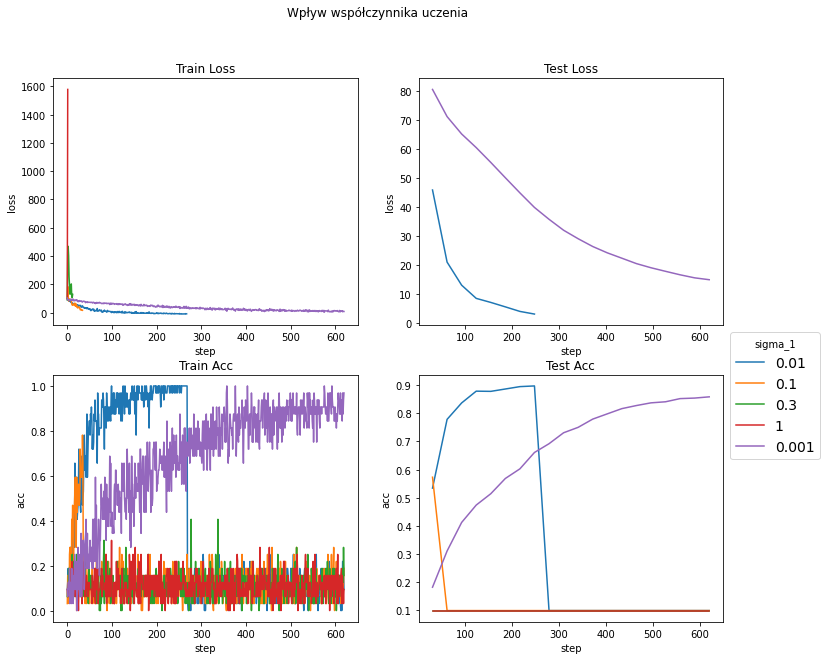

In [32]:
show_results(lr_res,baseline_lr, 'Wpływ współczynnika uczenia')